#  Лабораторная работа №6

In [ ]:
import sys
import math
import random
import warnings
import numpy as np
from functools import reduce
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def psi_1(x):
    return math.exp(-x) * math.cos(x)

def psi_2(x):
    return 0

def phi_0(t):
    return math.cos(2 * t)

def phi_l(t):
    return 0

def dpsi2_dx2(x):
    return 0

def u(x, t):
    return math.exp(-x) * math.cos(2 * t) * math.cos(x)

## Конечно-разностная схема


In [ ]:
class Schema:
    def __init__(self, psi1=psi_1, psi2=psi_2,
                 diffpsi2=dpsi2_dx2, f0=phi_0, fl=phi_l,
                 l0=0, l1=math.pi / 2, T=5, order2nd=True):
        self.psi1 = psi1
        self.diffpsi = diffpsi2
        self.psi2 = psi2
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None
        self.h = None
        self.order = order2nd
        self.sigma = None
        self.f0 = f0
        self.fl = fl

    def CalculateH(self, N):
        self.h = (self.l1 - self.l0) / N

    def CalculateTau(self, K):
        self.tau = self.T / K

    def CalculateSigma(self):
        self.sigma = self.tau*self.tau / (self.h*self.h)

    def Set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1

    def SetT(self, T):
        self.T = T

    @staticmethod
    def nparange(start, end, step = 1):
        curr = start
        e = 0.00000000001
        while curr - e <= end:
            yield curr
            curr += step

    def CalculateLine(self, t, x, lastLine1, lastLine2):
        pass

    def __call__(self, N=30, K=70):
        N, K = N - 1, K - 1
        self.CalculateTau(K)
        self.CalculateH(N)
        self.CalculateSigma()
        ans = []
        x = list(self.nparange(self.l0, self.l1, self.h))
        lastLine = list(map(self.psi1, x))
        ans.append(list(lastLine))
        if self.order:
            lastLine = list(map(lambda a: self.psi1(a) + self.tau * self.psi2(a) + self.tau * self.tau * self.diffpsi(a) / 2, x))
        else:
            lastLine = list(map(lambda a: self.psi1(a) + self.tau * self.psi2(a), x))
        ans.append(list(lastLine))
        X = [x, x]
        Y = [[0.0 for _ in x]]
        Y.append([self.tau for _ in x])
        for t in self.nparange(self.tau + self.tau, self.T, self.tau):
            ans.append(self.CalculateLine(t, x, ans[-1], ans[-2]))
            X.append(x)
            Y.append([t for _ in x])
        return X, Y, ans

### Явная конечно-разностная схема

In [ ]:
class ExplictSchema(Schema):
    def CalculateSigma(self):
        self.sigma =  self.tau * self.tau / (self.h * self.h)
        if self.sigma > 1:
            warnings.warn("Sigma > 1")

    def CalculateLine(self, t, x, lastLine1, lastLine2):
        line = [None for _ in lastLine1]
        for i in range(1, len(x) - 1):
            line[i] = self.sigma * (lastLine1[i - 1] - 2 * lastLine1[i] + lastLine1[i + 1])
            line[i] -= 3 * self.tau * self.tau * lastLine1[i]
            line[i] += 2 * lastLine1[i]
            line[i] += (self.tau - 1) * lastLine2[i]
            line[i] += self.tau * self.tau * (lastLine1[i + 1] - lastLine1[i - 1]) / self.h
            line[i] /= (1 + self.tau)
        line[0] = self.f0(t)
        line[-1] = self.fl(t)
        return line

### Неявная конечно-разностная схема

In [ ]:
class ImplictSchema(Schema):
    @staticmethod
    def SweepMethod(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
        x = [item for item in Q]
        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]
        return x

    def CalculateLine(self, t, x, lastLine1, lastLine2):
        a = 1 - self.h
        c = 1 + self.h
        b = -2 - 3*self.h*self.h - (1 + self.tau)/self.sigma
        A = [(a, b, c) for _ in range(2, len(x) - 2)]
        w = [((1 - self.tau) * lastLine2[i] - 2 * lastLine1[i]) / self.sigma for i in range(2, len(x)-2)]
        koeffs = (0, b, c, (((1 - self.tau) * lastLine2[1] - 2 * lastLine1[1]) / self.sigma) - a * self.f0(t))
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        koeffs = (a, b, 0, (((1 - self.tau) * lastLine2[-2] - 2 * lastLine1[-2]) / self.sigma) - c * self.fl(t))
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        ans = self.SweepMethod(A, w)
        ans.insert(0, self.f0(t))
        ans.append(self.fl(t))
        return ans

## Полученные результаты работы

## Зависимость погрешности от параметра *h*

In [ ]:
def Error(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            tmp = abs(z[i][j] - f(x[i][j], y[i][j]))
            ans = tmp if tmp > ans else ans
    return ans

In [ ]:
def GetStepHandEror(solver, real_f):
    h = []
    e = []
    for N in range(5, 30, 2):
        x, y, z = solver(N, 100)
        h.append(solver.h)
        e.append(Error(x, y, z, real_f))
    return h, e

### Явная схема

In [ ]:
explict = ExplictSchema(T=1)

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *

h, e = GetStepHandEror(explict, u)

trace1 = Scatter(
    x = h,
    y = e,
    name = 'Явная',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1]

layout = Layout(
    title = 'Зависимость погрешности от длины шага',
    xaxis = dict(title = 'h'),
    yaxis = dict(title = 'e'),
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)


trace1 = Scatter(
    x = list(map(math.log, h)),
    y = list(map(math.log, e)),
    name = 'Явная',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = [-3.5, -1],
    y = [-3, -0.5],
    name = 'Зависимость $O(h)$',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace3 = Scatter(
    x = [-3.5, -1],
    y = [-3, 2],
    name = 'Зависимость $O(h^2)$',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1]

layout = Layout(
    title = 'Зависимость погрешности от длины шага',
    xaxis = dict(title = 'log h'),
    yaxis = dict(title = 'log e'),
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

### Неявная схема

In [ ]:
implict = ImplictSchema(T=1)

In [ ]:
h, e = GetStepHandEror(implict, u)

trace1 = Scatter(
    x = h,
    y = e,
    name = 'Неявная',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1]

layout = Layout(
    title = 'Зависимость погрешности от длины шага',
    xaxis = dict(title = 'h'),
    yaxis = dict(title = 'e'),
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)


trace1 = Scatter(
    x = list(map(math.log, h)),
    y = list(map(math.log, e)),
    name = 'Неявная',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = [-3.5, -1],
    y = [-6, -1],
    name = 'Зависимость $O(h)$',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace3 = Scatter(
    x = [-3.5, -1],
    y = [-6, 4],
    name = 'Зависимость $O(h^2)$',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1, trace2, trace3]

layout = Layout(
    title = 'Зависимость погрешности от длины шага',
    xaxis = dict(title = 'log h'),
    yaxis = dict(title = 'log e'),
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

## Зависимость погрешности от параметра *tau*

In [ ]:
def GetTandError(methodToSolve, realF):
    tau, e = [], []
    for K in range(3, 90):
        x, y, z = methodToSolve(K=K)
        tau.append(methodToSolve.tau)
        e.append(Error(x, y, z, realF))
    return tau, e

### Явная схема

In [ ]:
explict = ExplictSchema(T=1)

In [ ]:
tau, e = GetTandError(explict, u)

trace1 = Scatter(
    x = tau,
    y = e,
    name = 'Явная',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1]

layout = Layout(
    title = 'Зависимость погрешности от мелкости разбиения по времени',
    xaxis = dict(title = 't'),
    yaxis = dict(title = 'e'),
)


fig = Figure(data = data, layout = layout)
offline.iplot(fig)

trace1 = Scatter(
    x = list(map(math.log, tau)),
    y = list(map(math.log, e)),
    name = 'Явная',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1]

layout = Layout(
    title = 'Зависимость погрешности от мелкости разбиения по времени',
    xaxis = dict(title = 'log t'),
    yaxis = dict(title = 'log e'),
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

<ipython-input-5-d161589d8095>:5: UserWarning:

Sigma > 1



### Неявная схема

In [ ]:
implict = ImplictSchema(T=1)

In [ ]:
tau, e = GetTandError(implict, u)

trace1 = Scatter(
    x = tau,
    y = e,
    name = 'Неявный',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1]

layout = Layout(
    title = 'Зависимость погрешности от мелкости разбиения по времени',
    xaxis = dict(title = 'h'),
    yaxis = dict(title = 'e'),
)


fig = Figure(data = data, layout = layout)
offline.iplot(fig)

trace1 = Scatter(
    x = list(map(math.log, tau)),
    y = list(map(math.log, e)),
    name = 'Неявный',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = [-4, 0],
    y = [-4.5, -1.5],
    name = 'Зависимость $O(t)$',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace3 = Scatter(
    x = [-4, 0],
    y = [-4, -2],
    name = 'Зависимость $O(\sqrt{t})$',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1, trace2, trace3]

layout = Layout(
    title = 'Зависимость погрешности от мелкости разбиения по времени',
    xaxis = dict(title = 'log t'),
    yaxis = dict(title = 'log e'),
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)


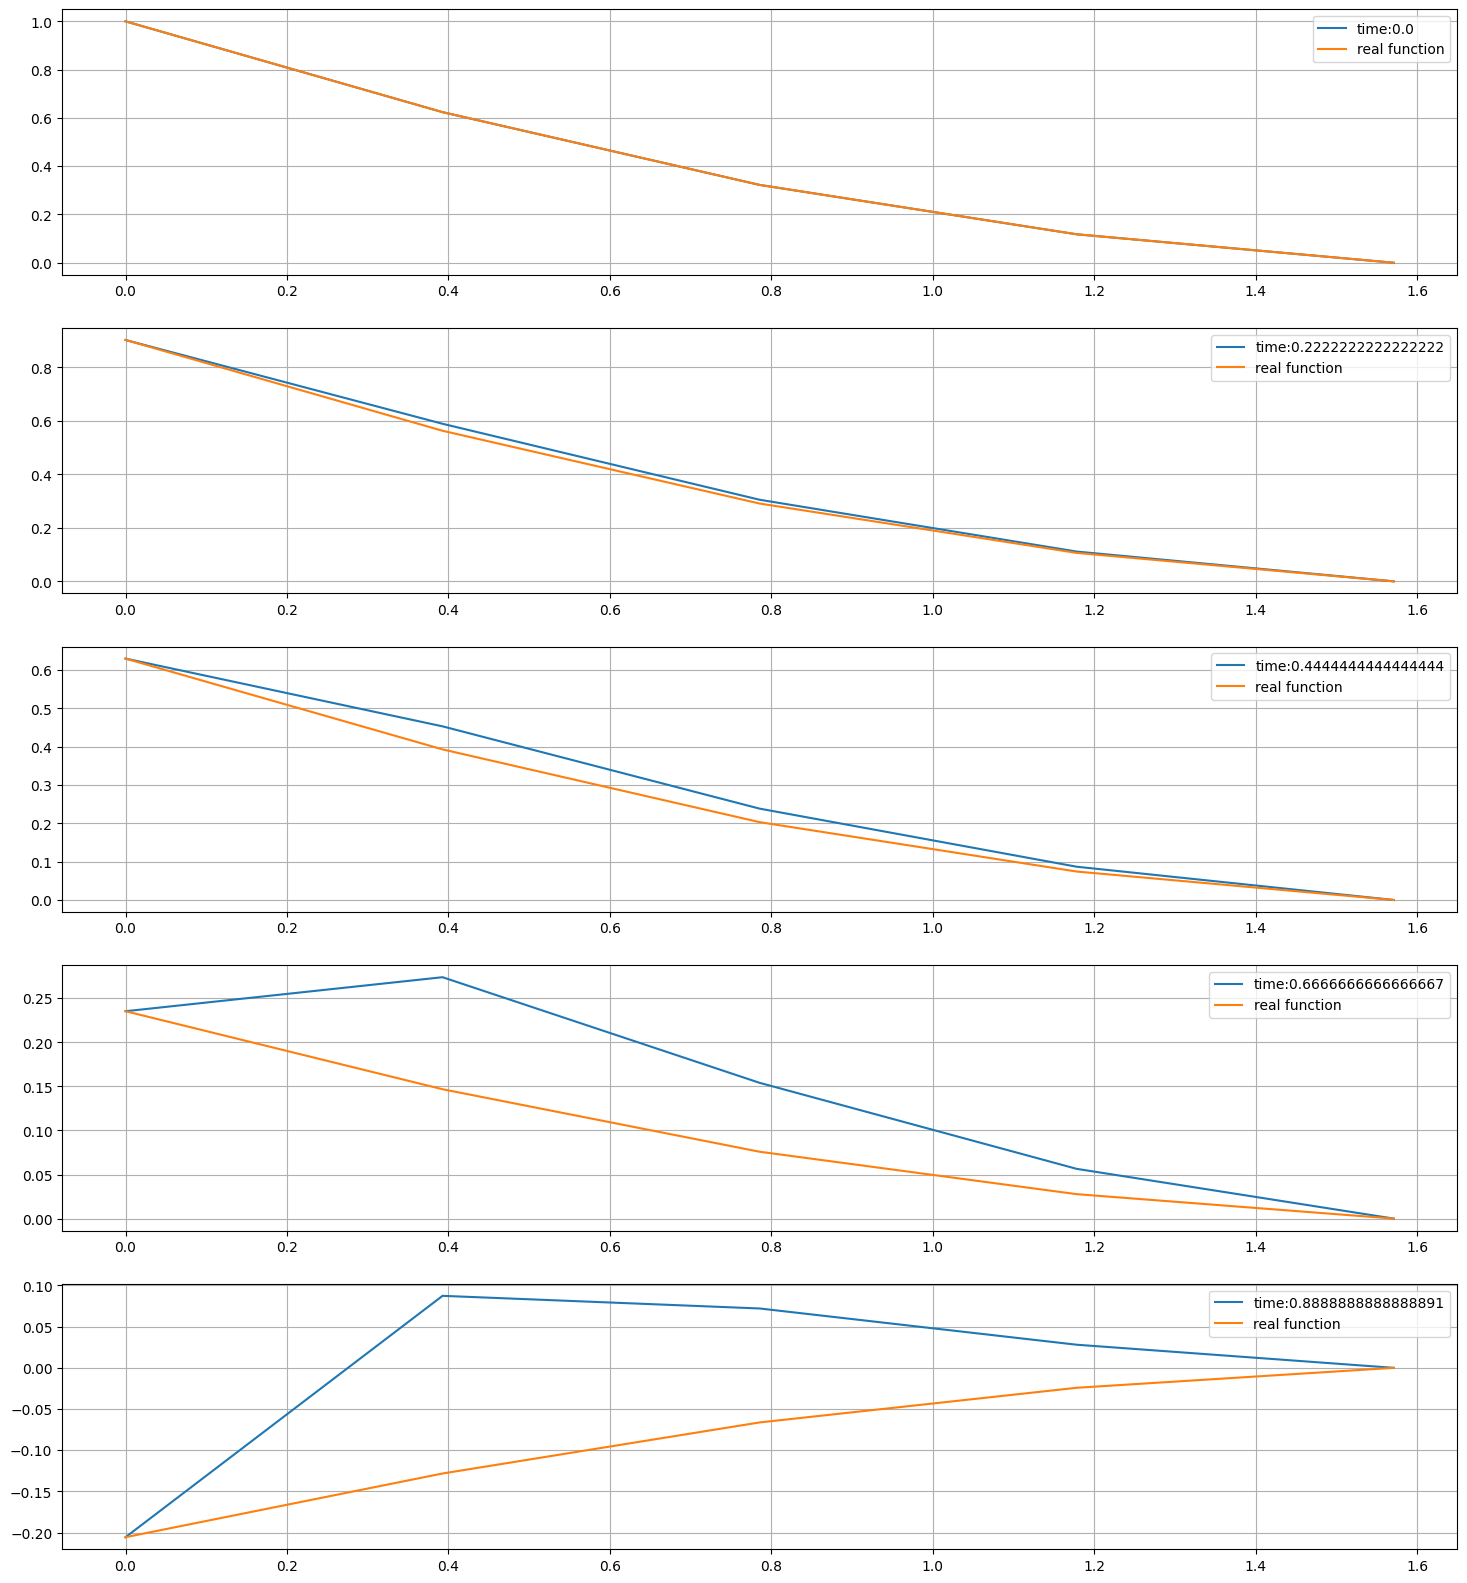

In [ ]:
# неявная
def plotDependenceT(n=5, k=10, t=1):
    schema = ImplictSchema(T=t)
    x, y, z = schema(N=n, K=k)
    plt.figure(figsize=(18, 20))
    for i in range(1, 6):
        plt.subplot(5, 1, i)
        j = (k * (i - 1)) // 5
        X = x[j]
        Z = z[j]
        T = y[j][0]

        plt.plot(X, Z, label="time:" + str(T))
        plt.plot(X, list(map(lambda o: u(o, T), X)), label='real function')
        # plt.plot(X, returnListU(X, T), label = 'real function')
        plt.grid()
        plt.legend()

plotDependenceT()